In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import logging
import io
import seaborn as sns
import sys
import platform
from scipy import stats
import itertools
sys.path.append('/home/yat-lok/workspace/tvbtools/')
from tools.statools import stats_calculator
"""
Author: Yile
This script is designed to calculate the the direct weight connection
"""

In [ ]:
def violin_plot(dataframe, column):
    fig = plt.figure(figsize=(10,10))
    plt.title('Homotopic-Streamlines')
    fig = sns.violinplot(x="grp", y=column, data=dataframe, capsize=.2,palette=["#66CDAA","#4682B4","#AB63FA","#FFA15A"])
    fig = sns.stripplot(x="grp", y=column, data=dataframe,color='black')
    fig = sns.pointplot(data=dataframe, x='grp', y=column, join=False, ci=None, color='red')
    # fig.set_ylim(-0.5, 1)
    # fig.set_yticks(np.arange(-0.5, 1, 0.1))
    plt.show()

In [ ]:

# brain regions labels
regions = ['aCNG-L', 'aCNG-R','mCNG-L','mCNG-R','pCNG-L','pCNG-R', 'HIP-L','HIP-R','PHG-L','PHG-R','AMY-L','AMY-R', 'sTEMp-L','sTEMp-R','mTEMp-L','mTEMp-R']
cmap = sns.diverging_palette(230, 20, as_cmap=True)
col = ["#66CDAA","#4682B4","#AB63FA","#FFA15A"]
limbic = ['aCNG', 'mCNG', 'pCNG', 'HIP', 'PHG','AMY','sTEMp','mTEMp']
grp_pools = ['SNC', 'NC','MCI', 'AD']
start = time.time()
pdList = []
head = ['group', 'caseid']
# fig, axs = plt.subplots(2, sharex = True, sharey = True, figsize=(12,8))
# fig.suptitle("G frequency and Gamma")


tmp_head = np.concatenate((head, limbic), axis=0)
df_inter = pd.DataFrame(columns=tmp_head)
hetero_sc_data_left = pd.DataFrame(columns=tmp_head)
hetero_sc_data_right = pd.DataFrame(columns=tmp_head)
mean_group_matrix = np.zeros((16, 16, 4))
for indx, grp in enumerate(grp_pools):
# obtain the data path
    pth = "/mnt/c/Users/Wayne/tvb/AUS/" + grp
    case_pools = os.listdir(pth)
    group_matrix = np.zeros((16, 16, len(case_pools)))
    for ind, caseid in enumerate(case_pools):
        ### the structural connectivity ###
        # SC lateralization
        # fig, (ax0, ax1) = plt.subplots(1,2, figsize=(15,5))
        # fig.suptitle(grp+'_'+caseid)
        datapath = '/mnt/c/Users/Wayne/tvb/AUS/' + grp + '/' + caseid + '/weights.txt'
        scl = open(datapath,"r")
        lines = scl.read()
        tmp_d = pd.read_csv(io.StringIO(lines), sep='\t', header=None, index_col=None, engine="python")
        tmp_df = tmp_d.set_axis(regions, axis=0) # set the index
        df_sc = tmp_df.set_axis(regions, axis=1) # set the columns
        group_matrix[:,:,ind] = df_sc
        # sns.heatmap(df_sc,cmap='coolwarm')
        # plt.show()
        ### the lateralization ###

        #the direct lateralization
        # ind = np.arange(0, 16, 2)
        # m = []
        # for n in ind:
        #     tmp = df_sc.iloc[n+1, n]
        #     m.append(tmp)

        ###
        # The homotopic connectivity
        connect = np.array([])
        hetero = np.array([])
        tmp_hetero_left = np.array([])
        tmp_hetero_right = np.array([])
        for index in range(len(limbic)):
            # homotopic
            tmp_connect = df_sc.iloc[2*index+1, 2*index]
            connect = np.append(connect, tmp_connect)
        tmp_c = np.concatenate(([grp, caseid], connect)).reshape((10,1)).T
        tmp_c2 = pd.DataFrame(tmp_c, columns=tmp_head)
        df_inter = pd.concat([df_inter, tmp_c2], ignore_index=True)
        for index in range(len(regions)):
            # heterotopic
            tmp_left = []
            tmp_right = []
            if index % 2 == 0:
                for indxx in range(1,17,2):
                    if indxx - index != 1:
                        tmp_left.append(df_sc.iloc[indxx, index])
                tmp_hetero_left = np.append(tmp_hetero_left, sum(tmp_left)/7)
            else:
                for indxx in range(0, 16, 2):
                    if index - indxx != 1:
                        tmp_right.append(df_sc.iloc[indxx+1, index])
                tmp_hetero_right = np.append(tmp_hetero_right, sum(tmp_right)/7)
        
        tmp_left_c = np.concatenate(([grp, caseid], tmp_hetero_left)).reshape((10,1)).T
        tmp_left_c2 = pd.DataFrame(tmp_left_c, columns=tmp_head)
        tmp_right_c = np.concatenate(([grp, caseid], tmp_hetero_right)).reshape((10,1)).T
        tmp_right_c2 = pd.DataFrame(tmp_right_c, columns=tmp_head)
        hetero_sc_data_left = pd.concat([hetero_sc_data_left, tmp_left_c2], ignore_index=True)
        hetero_sc_data_right = pd.concat([hetero_sc_data_right, tmp_right_c2], ignore_index=True)
    end = time.time()
    logging.warning('Duration: {}'.format(end - start))
    mean_group_matrix[:,:,indx] = np.mean(group_matrix, axis=2)
# direct_sc_data.to_excel("sc_data.xlsx")
# hetero_sc_data_left.to_excel("sc_hetero_left.xlsx")
# hetero_sc_data_right.to_excel("sc_hetero_right.xlsx")
# figure = plt.figure(figsize=(25,25))
# sns.set(font_scale=2)
# for i in range(len(grp_pools)):
#     plt.subplot(2,2,i+1)
#     plt.title(grp_pools[i])
#     heat = sns.heatmap(mean_group_matrix[:,:,i], cmap="coolwarm", vmin=0, vmax=80, xticklabels=regions, yticklabels=regions)
#     heat.set_xticklabels(heat.get_xticklabels(), rotation=45)
# plt.savefig("heatmap_weight.png", dpi=100)


    
    # avg_direct_sc = pd.DataFrame({'grp':direct_sc_data.iloc[:,0],'avg_direct_sc':np.mean(np.array(direct_sc_data.iloc[:, 2:].values).astype('float'), axis=1)}
    # print(stats_calculator(avg_direct_sc))
    # violin_plot(avg_direct_sc, "avg_direct_sc")

    # avg_hetero_sc_left = pd.DataFrame({'grp':hetero_sc_data_left.iloc[:,0],'avg_hetero_sc_left':np.mean(np.array(hetero_sc_data_left.iloc[:, 2:].values).astype('float'), axis=1)})

    # avg_hetero_sc_right = pd.DataFrame({'grp':hetero_sc_data_right.iloc[:,0],'avg_hetero_sc_right':np.mean(np.array(hetero_sc_data_right.iloc[:, 2:].values).astype('float'), axis=1)})
    # print(stats_calculator(avg_hetero_sc_right))
    # violin_plot(avg_hetero_sc_right, "avg_hetero_sc_right")


In [ ]:
left = hetero_sc_data_left.iloc[:,2].astype(float).to_numpy()
right = hetero_sc_data_right.iloc[:,2].astype(float).to_numpy()
stack = np.array([left,right])
avg = np.mean(stack, axis = 0)
df_hetero = pd.DataFrame()

for i in range(2,10):
    left = hetero_sc_data_left.iloc[:,i].astype(float).to_numpy()
    right = hetero_sc_data_right.iloc[:,i].astype(float).to_numpy()
    stack = np.array([left,right])
    avg = np.mean(stack, axis = 0)
    tmp = pd.DataFrame({limbic[i-2]:avg})
    df_hetero = pd.concat([df_hetero, tmp], axis = 1)
df_hetero = pd.concat([hetero_sc_data_left.iloc[:,:2], df_hetero], axis=1)
df_hetero.to_excel("/mnt/c/Users/Wayne/tvb/gc1sec_res/hetero_weights.xlsx")
# df_merge = pd.DataFrame()
# for ind, i in enumerate(range(0,15,2)):
#     left = df_hetero.iloc[:,i].to_numpy()
#     right = df_hetero.iloc[:,i+1].to_numpy()
#     stack = np.array([left,right])
#     avg = np.mean(stack, axis = 0)
#     tmp = pd.DataFrame({limbic[ind]:avg})
#     df_merge = pd.concat([df_merge, tmp], axis = 1)
# print(df_merge)
# df_hetero.to_excel("/mnt/c/Users/Wayne/tvb/gc1sec_res/hetero_weights.xlsx")

### generate plots with only left connections and only right connections

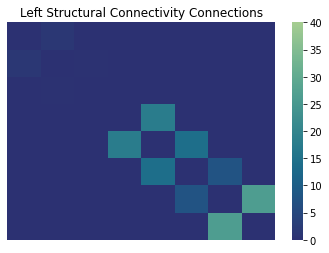

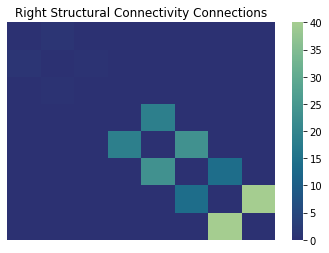

In [64]:
import seaborn as sns
import numpy as np
import pandas as pd
import io
import matplotlib.pyplot as plt
# brain regions labels
regions = ['aCNG-L', 'aCNG-R','mCNG-L','mCNG-R','pCNG-L','pCNG-R', 'HIP-L','HIP-R','PHG-L','PHG-R','AMY-L','AMY-R', 'sTEMp-L','sTEMp-R','mTEMp-L','mTEMp-R']
cmap = sns.diverging_palette(230, 20, as_cmap=True)
col = ["#66CDAA","#4682B4","#AB63FA","#FFA15A"]
limbic = ['aCNG', 'mCNG', 'pCNG', 'HIP', 'PHG','AMY','sTEMp','mTEMp']
grp_pools = ['SNC', 'NC','MCI', 'AD']

path = '/home/yat-lok/workspace/data4project/lateralization/tvb_parameters.xlsx'
coData = pd.read_excel(path)

all_mat_left = np.zeros((8,8,len(coData.groups)))
all_mat_right = np.zeros_like(all_mat_left)

output_df = pd.DataFrame()
count = 0
for grp, caseid in zip(coData.groups, coData.caseid):
    ### the structural connectivity ###
    # SC lateralization
    # fig, (ax0, ax1) = plt.subplots(1,2, figsize=(15,5))
    # fig.suptitle(grp+'_'+caseid)
    datapath = '/home/yat-lok/workspace/data4project/lateralization/connectome/' + grp + '/' + caseid + '/weights.txt'
    scl = open(datapath,"r")
    lines = scl.read()
    tmp_d = pd.read_csv(io.StringIO(lines), sep='\t', header=None, index_col=None, engine="python")
    tmp_df = tmp_d.set_axis(regions, axis=0) # set the index
    df_sc = tmp_df.set_axis(regions, axis=1) # set the columns
    tmp_mat_left = np.zeros((8,8))
    tmp_mat_right = np.zeros_like(tmp_mat_left)
    for ind, i in enumerate(range(0, 14, 2)):
        for _, j in enumerate(range(i, 16, 2)):
            tmp_mat_left[ind+1,ind] = df_sc.iloc[j,i]
            tmp_mat_right[ind+1,ind] = df_sc.iloc[j+1,i+1]
    values_left = tmp_mat_left[np.nonzero(tmp_mat_left)]
    values_right = tmp_mat_right[np.nonzero(tmp_mat_right)]

    flat_left= pd.Series(values_left.flatten())
    flat_right = pd.Series(values_right.flatten())
    grp_info = pd.Series([grp])
    grp_col = grp_info.repeat(len(flat_right))
    grp_col = grp_col.reset_index(drop=True)
    case_info = pd.Series([caseid])
    case_col = case_info.repeat(len(flat_right))
    case_col = case_col.reset_index(drop=True)
    _tmp = pd.concat([grp_col, case_col, flat_left, flat_right],axis=1, ignore_index=True)
    output_df = pd.concat([output_df, _tmp], ignore_index=True)

    sym_mat_left = tmp_mat_left + tmp_mat_left.T
    sym_mat_right = tmp_mat_right + tmp_mat_right.T
    all_mat_left[:,:,count] = sym_mat_left
    all_mat_right[:,:,count] = sym_mat_right
    count += 1
output_df.columns = ["group", "caseid", "left", "right"]
#output_df.to_excel('/home/yat-lok/workspace/data4project/lateralization/gc1sec_res/sc_left_right.xlsx')
a = [0, 10, 26, 61, 76]


sns.heatmap(np.mean(all_mat_left, axis=2), vmax=40, xticklabels=[], yticklabels=[], cmap="crest_r").set(title='Left Structural Connectivity Connections')
plt.show()
sns.heatmap(np.mean(all_mat_right, axis=2), vmax = 40, xticklabels=[], yticklabels=[], cmap="crest_r").set(title='Right Structural Connectivity Connections')
plt.show()
